# Shoals Marine Lab Water Energy Dynamic System Model

## Introduction
The below figure represents a simplified schema of the model, which contains two main components: an energy sub-model and a water sub-model. The energy sub-model simulates wind, solar, and diesel energy supply, alongside energy demand and balance. Particularly, wind energy output is calculated based on prevailing wind speeds at each time step, while solar energy is estimated using instantaneous solar radiation and ambient temperature, following equations from Ren et al. (2020) and Lilienthal (2005). Diesel serves as a backup power source, with its operation governed by predefined rules that consider battery storage levels, energy demand, and renewable energy availability. Any excess renewable energy is not utilized. Further details on the energy sub-model's operation can be found in Ghasemi et al (2023). 

The water sub-model simulates the processes and energy use associated with groundwater and seawater intake, treatment, and distribution. The energy uses for these unit processes are determined by the activation of their respective pumps and corresponding flow rates. When a pump is operating, its energy consumption is calculated as the product of its activation and power rating per minute. To enhance the utilization of surplus renewable energy and conserve groundwater for system resilience, a groundwater recharge mechanism was added to the model. When both the cistern and pressurized tanks reach their maximum operational capacities and surplus renewable energy is available, the excess renewable energy is used to desalinate water, which is then diverted to recharge the groundwater well. To model changes in the groundwater well level, a “bathtub” model was developed as a simplified representation of the island’s watershed. This model conceptualizes the watershed as a rectangular storage tank. The tank is replenished by precipitation and groundwater recharge and depleted through groundwater withdrawal.

<p align="center">
    <img src="image.png" alt="A schematic of the process-based energy-water microgrid simulation model">
</p>



___
### 1. Libraries

In [1]:
# pip install pandas numpy tqdm matplotlib openpyxl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### 2. Import data

In [2]:
# Load csv files
Data22 = pd.read_csv('Input Data/Input Data 2022.csv')
Power_Table = pd.read_csv('Input Data/Power table.csv')

# Initial Vectors
GHI_W_m2_v = Data22.loc[:, 'GHI (W/m2)']
Wind_spd_IOSN3_v = Data22.loc[:, 'WindSpeedIOSN3 (m/s)']
Ambient_temp_v = Data22.loc[:, 'AirTemperature (degrees C)']
EDemand_v = Data22.loc[:, 'Demand (W)']
WDemand_v = Data22.loc[:, 'Demand tPlusDifference (gal)']
R_v = Data22.loc[:, 'Rain (in)']
RO_switch_v = Data22.loc[:, 'RO_Switch']
Well_pump_switch_v = Data22.loc[:, 'Well_Switch']

#Constants
RO_Rate = 3
Well_Rate = 14.5
Cistern_Rate = 14.5

Battery_total_cap_kWh=250
Lowest_H_Well = 100
Highest_H_Well = 240
Cistern_Max = 14000

#Simulation start time in 2022
init_day = 152
init_h = 0
Gen_switch_init = 0
Cistern_pump_switch_init = 0
Battery_SOC_init = 78
Pressure_Tank_init = 4000
Cistern_Tank_init = 14000
H_Well_init = 188.8

GHI_W_m2_init = Data22.loc[0, 'GHI (W/m2)'].item()
Wind_spd_IOSN3_init = Data22.loc[0, 'WindSpeedIOSN3 (m/s)'].item()
Ambient_temp_init = Data22.loc[0, 'AirTemperature (degrees C)'].item()
EDemand_init = Data22.loc[0, 'Demand (W)'].item()
WDemand_init = Data22.loc[0, 'Demand tPlusDifference (gal)'].item()
R_init = Data22.loc[0, 'Rain (in)'].item()

State_initial = [0, Gen_switch_init, Cistern_pump_switch_init, Battery_SOC_init, Pressure_Tank_init, Cistern_Tank_init, H_Well_init, WDemand_init, EDemand_init, GHI_W_m2_init, Ambient_temp_init, Wind_spd_IOSN3_init, R_init]



#Time horizon
T = 92*24*60



# Energy Supply
___
## 1. Solar PV

In [3]:
###Time of the day and the year
#Input: time of the year or time of the day - Scalar
#Output: time of the year or time of the day - Scalar

def Time_Day(t,init_h=0): #0 means 12 am 1 means 12:01 anso on - minutes shift
    Civil_time= ((t-(1440*int(t/1440)))*(24/1440))+(init_h*(24/1440))
    return Civil_time


def Time_Year(t,init_day=152): #This function calculates the civil time
    Day_of_year = (init_day+(t/1440))//1
    return Day_of_year

#Input: Time step, GHI [W/m2], temperature [degree c]
#Output: PV Generation load at minute t [kW]
def PV_Gen(t, GHI_W_m2, Ambient_temp, Module_eff=0.155):
    #Inputs:
    Time = t
    Day_of_year = Time_Year(t)
    Local_standard_time = Time_Day(t)
    
    # Variables
    GHI_kW_m2 = 0 if GHI_W_m2 < 25 else GHI_W_m2 / 1000
    Slope_d = 20
    Azimuth_d = 170
    Slope_of_surface_r = Slope_d/180
    Azimuth_gamma_r = Azimuth_d/180
    Ground_ref_albedo = 0.1
    Solar_constant = 1.367
    Longitude_d = -70.78
    Longitude_r = Longitude_d/180
    Time_zone = -4
    Latitute_Phi_d = 43.01
    Latitute_Phi_r = Latitute_Phi_d/180
    B = 360*((Day_of_year-1)/365)
    E = 3.82*(7.5e-005+0.001868*np.cos(B)-0.032077*np.sin(B) -
              0.014615*np.cos(2*B)-0.04089*np.sin(2*B))
    Solar_time_ts = Local_standard_time+(Longitude_r/15)-Time_zone+E
    Hour_angle_omega = (Solar_time_ts-12)*15/180
    Solar_declination_delta = 23.45 * \
        np.sin(((360*((284+Day_of_year)/365)))/180)/180  # radian
    Angle_of_incident_Cos_theta = np.sin(Solar_declination_delta)*np.sin(Latitute_Phi_r)*np.cos(Slope_of_surface_r)-np.sin(Solar_declination_delta)*np.cos(Latitute_Phi_r)*np.sin(Slope_of_surface_r)*np.cos(Azimuth_gamma_r)+np.cos(Solar_declination_delta)*np.cos(Latitute_Phi_r)*np.cos(
        Slope_of_surface_r)*np.cos(Azimuth_gamma_r)+np.cos(Solar_declination_delta)*np.sin(Latitute_Phi_r)*np.sin(Slope_of_surface_r)*np.cos(Azimuth_gamma_r)*np.cos(Hour_angle_omega)+np.cos(Solar_declination_delta)*np.sin(Slope_of_surface_r)*np.sin(Azimuth_gamma_r)*np.sin(Hour_angle_omega)
    Zenith_angle_Cos_theta_z = np.cos(Latitute_Phi_r)*np.cos(Solar_declination_delta)*np.cos(
        Hour_angle_omega)+np.sin(Latitute_Phi_r)*np.sin(Solar_declination_delta)
    The_extraterrestrial_normal_radiation = Solar_constant * \
        (1+0.033*np.cos(360*Day_of_year/365))
    # The ratio of beam radiation on the tilted surface to beam radiation on the horizontal surface Rb
    Rb = Angle_of_incident_Cos_theta/Zenith_angle_Cos_theta_z
    Extraterrestrial_h_radiation_avg = (12/3.1415)*The_extraterrestrial_normal_radiation*(np.cos(Latitute_Phi_r)*np.cos(Solar_declination_delta)*(np.sin(Hour_angle_omega+0.25)-np.sin(
        Hour_angle_omega))+(3.1415*0.25*np.sin(Latitute_Phi_r)*np.sin(Solar_declination_delta)/180))  # The extraterrestrial horizontal radiation averaged over the time step
    Kt = GHI_kW_m2/(Extraterrestrial_h_radiation_avg)  # Clearness index Kt
    
    Diff_less = GHI_kW_m2*(1-0.09*Kt) if Kt <= 0.22 else 0
    Diff_more = GHI_kW_m2*0.165 if Kt > 0.80 else 0
    Diff_between = GHI_kW_m2*(0.9511-0.1604*Kt+4.388*Kt**2-16.638*Kt**3+12.336*Kt**4) if Kt > 0.22 else 0
    Diff_between = 0 if Kt > 0.80 else Diff_between
     
    Diff_radiation = Diff_less+Diff_more+Diff_between
    Beam_radiation = GHI_kW_m2-Diff_radiation
    Ai = Beam_radiation/Extraterrestrial_h_radiation_avg  # Anisotropy index Ai
    # Cloudiness factor f
    f_Cloud = 0 if GHI_kW_m2==0 else np.sqrt(Beam_radiation/GHI_kW_m2)
        
    PV_incident_radiation = (Beam_radiation+Diff_radiation*Ai)*Rb+Diff_radiation*(1-Ai)*((1+np.cos(Slope_of_surface_r))/2)*(
        1+f_Cloud*np.sin(Slope_of_surface_r/2)**3)+GHI_kW_m2*Ground_ref_albedo*((1-np.cos(Slope_of_surface_r))/2)

    # PV generation
    Old_panels = 233
    New_panels = 0
    Number_of_PV_installed = Old_panels + New_panels
    
    
    Solar_radiation_incident_on_PV_array_GHI = PV_incident_radiation*1000
    Inverter_eff = 1
    PV_derating_factor = 0.95
    System_losses = 0.15
    Average_res_PV_size = 1.83
    Total_array_area = Average_res_PV_size*Number_of_PV_installed
    Rated_cap_PV_array = Total_array_area*Module_eff
    The_nominal_operating_cell_temp = (45+48)/2
    Temp_coef_power = -0.0048
    # The maximum power point efficiency under standard test conditions
    Max_power_point_eff_test_condition = 0.13
    Solar_radiation_NOCT = 0.8  # The solar radiation at which the NOCT is defined
    Ambient_temp_NOCT = 20  # The ambient temperature at which the NOCT is defined
    PV_cell_temp_std_test = 25
    Target_temp_w_cooling = 80
    Incident_radiation_at_std = 1
    Degradation_rate = 0.005
    # The solar transmittance of any cover over the PV array
    PV_transmittance_cover_over_PV_array = 0.9
    Solar_absorptance_PV = 0.9  # The solar absorptance of the PV array
    System_degradation = Degradation_rate/(365*24*60)
    # The efficiency of the PV array at its maximum power point
    PV_eff_at_max_power = Max_power_point_eff_test_condition
    Solar_radiation_incident_on_PV_array_GHI = PV_incident_radiation*1000
    coeff_heat_transfer_to_surrondings = Solar_absorptance_PV*PV_transmittance_cover_over_PV_array*Solar_radiation_NOCT / \
        (The_nominal_operating_cell_temp -
         Ambient_temp_NOCT)  # The coefficient of heat transfer to the surroundings
    Temp_sens_analysis = 1
    PV_cell_temp_in_current_time_step = (Ambient_temp*Temp_sens_analysis)+((Solar_radiation_incident_on_PV_array_GHI)/1000)*(
        (Solar_absorptance_PV*PV_transmittance_cover_over_PV_array)/coeff_heat_transfer_to_surrondings)*(1-PV_eff_at_max_power/(Solar_absorptance_PV*PV_transmittance_cover_over_PV_array))
    
    PV_cell_temp_under_cooling_in_current_time_step = Target_temp_w_cooling if PV_cell_temp_in_current_time_step > Target_temp_w_cooling else PV_cell_temp_in_current_time_step
    
    PV_array_output = ((Rated_cap_PV_array*PV_derating_factor*(((Solar_radiation_incident_on_PV_array_GHI))/Incident_radiation_at_std)*(
        1+Temp_coef_power*(PV_cell_temp_under_cooling_in_current_time_step-PV_cell_temp_std_test)))*Inverter_eff*(1-System_losses))*(1-System_degradation)**Time

    PV_gen = PV_array_output/1000
    
    return PV_gen


PV_gen = PV_Gen(85, 25, 23, Module_eff=0.155)
print(PV_gen, "kW - minute load")

1.3379271367034633 kW - minute load


## 2. Wind turbine

In [4]:
#Input: Wind speed at each time [m/s] and power table (converts wind speed to generation load)
#Output: Wind generation load at each time [kW]
def Wind_Gen(Wind_spd_IOSN3, Power_Table=Power_Table):
    # Variables
    Height_conversion = 1.017
    Wind_spd_adjusted = round(Wind_spd_IOSN3*Height_conversion, 1)
    
    if Wind_spd_adjusted>20.5:
        Wind_power = 11500.0
    else:
        row = Power_Table[Power_Table["Wind"] == Wind_spd_adjusted]
        
        Wind_power = row["Power"].values[0] if not row.empty else None
    
    Wind_gen = Wind_power/1000

    return Wind_gen

Wind_gen = Wind_Gen(2.5)

print(Wind_gen, "kW - minute load")

0.039 kW - minute load


## 3. Diesel generator

In [5]:
#Input: Previous Gen Switch (0 or 1), DC BUS Energy (current) [kWmin], Total_Demand [W], PV and wind generation [kW]
#Output: Diesel Generation [kW], Next Gen Switch (0 or 1)

def Diesel_Gen(Gen_switch, DC_BUS, Total_Demand, PV_gen, Wind_gen, Battery_total_cap_kWh=250 , Gen_upper_bound=0.78, Gen_lower_bound=0.70, Diesel_gen_cap=2*27):
    # Diesel gen
    
    Battery_total_cap_kWm = Battery_total_cap_kWh*60
    SOC = DC_BUS/Battery_total_cap_kWm
    
    if Battery_total_cap_kWm == 0:
        Excess_gen_production = 0
    else:
        Excess_gen_production = 0.32

    if Diesel_gen_cap >= ((1+Excess_gen_production)*(Total_Demand/1000)) and Gen_switch == 1:
        Diesel_electricity_generation = ((1+Excess_gen_production)*(Total_Demand/1000))
    else:
        Diesel_electricity_generation = Gen_switch*Diesel_gen_cap
    
    ## Conditions to transit the state of the switch:
    
    if 0<=SOC<=Gen_lower_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm<(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 0
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm>=(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 1
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen):
        Gen_switch = 1
        
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_lower_bound-SOC)*Battery_total_cap_kWm<(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 0
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_lower_bound-SOC)*Battery_total_cap_kWm>=(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 1
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen):
        Gen_switch = 1
    
    
    
    
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm<(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 0
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm>=(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 1
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen):
        Gen_switch = 1
    
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen):
        Gen_switch = 0
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm<(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 1
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm>=(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 0



    elif Gen_upper_bound <=SOC and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen):
        Gen_switch = 0
    elif Gen_upper_bound <=SOC and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm>=(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 0
    elif Gen_upper_bound <=SOC and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm<(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 1
    
    elif Gen_upper_bound <=SOC and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen):
        Gen_switch = 0
    elif Gen_upper_bound <=SOC and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm<(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 1
    elif Gen_upper_bound <=SOC and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm>=(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 0
    
    else:
        Gen_switch = 10
    
    return Diesel_electricity_generation, Gen_switch

Diesel_electricity_generation, Gen_switch = Diesel_Gen(1, 14000, 1500, 10, 5.6)

print(f"Diesel generation at this time is equal to {Diesel_electricity_generation} kW, and for the next time step the generator is {'ON' if Gen_switch > 1 else 'OFF'}")

Diesel generation at this time is equal to 1.98 kW, and for the next time step the generator is OFF


# Energy Balance of the System
___

In [6]:
#Input: DC BUS energy [kWm], PV load [kW], wind load [kW], diesel generation load [kW], total demand [W]
#Output: DC BUS energy [kWm],battery state of charge [%], excess energy (wasted energy) [kW], excess energy signal (Just a signal for waste)
def BoSys(DC_BUS, PV_gen, Wind_gen, Diesel_electricity_generation, Total_Demand,  Excess_gen_production=0.32, DCtoAC_eff=0.925, Battery_total_cap_kWh=250):
    # BOS
    Battery_total_cap_kWm = Battery_total_cap_kWh*60

    if Diesel_electricity_generation ==0:
        Gen_switch = 0
    else:
        Gen_switch = 1
    
    Energy_gain_from_gen = Diesel_electricity_generation * (Excess_gen_production)/(1+Excess_gen_production)

    Consumption_from_DC_BUS = (1-Gen_switch) * Total_Demand*DCtoAC_eff/1000

    if (PV_gen + Wind_gen + Energy_gain_from_gen - Consumption_from_DC_BUS) < 0 and Battery_total_cap_kWm == 0:
        Excess_energy = PV_gen + Wind_gen + Energy_gain_from_gen - Consumption_from_DC_BUS
        Excess_energy_signal = 1
    elif (Battery_total_cap_kWm-DC_BUS) > (PV_gen + Wind_gen + Energy_gain_from_gen - Consumption_from_DC_BUS):
        Excess_energy = 0
        Excess_energy_signal = 0
    else:
        Excess_energy = (PV_gen + Wind_gen + Energy_gain_from_gen-Consumption_from_DC_BUS)-(Battery_total_cap_kWm-DC_BUS)
        Excess_energy_signal = 1
    
    DC_BUS = DC_BUS + PV_gen + Wind_gen + Energy_gain_from_gen - Excess_energy - Consumption_from_DC_BUS

    Battery_SOC = DC_BUS*100/Battery_total_cap_kWm

    return DC_BUS, Battery_SOC, Excess_energy, Excess_energy_signal


# Water Supply
___
## 1. RO desalination system

In [7]:
#Input: RO Switch (0 or 1)
#Output: Ro Flow Rate [gal] - Scalar

def RO(RO_switch, RO_desalination_rate=RO_Rate):
    
    RO_water_flow=RO_desalination_rate * RO_switch
    
    return RO_water_flow

RO_water_flow = RO(1, RO_desalination_rate=RO_Rate)
print(f'RO system is {'ON' if RO_water_flow > 1 else 'OFF'} and generates {RO_water_flow } gal in one minute')

RO system is ON and generates 3 gal in one minute


## 2. Well water supply

In [8]:
#Input: Well Switch (0 or 1)
#Output: Well Water Flow Rate [gal] - Scalar
def Well(Well_pump_switch, H_Well, Lowest_H_Well=Lowest_H_Well , Well_rate = Well_Rate):
    
    if H_Well <= Lowest_H_Well:
        Well_water_flow = 0 # well is dried!
    else:
        Well_water_flow = Well_rate * Well_pump_switch
    
    return Well_water_flow 

Well_water_flow = Well(1, 170)
print(f'Well water system is {'ON' if Well_water_flow > 1 else 'OFF'} and generates {Well_water_flow } gal in one minute')

Well water system is ON and generates 14.5 gal in one minute


# Water Storage
___
## 1. Presurized tank level

In [9]:
#Input: P tank level [gal], cistern tank level [gal], Water  Demand [gal], cistern pump current status (0 or 1)
#Output: Cistern pump updated status, updated presure Tank Level [gal], incoming water flow [gal], Water Shortage Signal (0 or 1)

def PTank(Pressure_Tank, Cistern_Tank, WDemand, Cistern_pump_switch, Cistern_pump_flow_rate=Cistern_Rate, Pressure_tank_withdraw_size=5000, P_tank_up = 0.8, P_tank_low = 0.2, Water_shortage=0):
  
    if Pressure_Tank <=0:
        if Cistern_Tank>=Cistern_pump_flow_rate:
            Cistern_pump_switch = 1
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Water_shortage = 0
        else:
            Cistern_pump_switch = 0
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Pressure_Tank = 0
            Water_shortage= -Pressure_Tank
        
    elif Pressure_Tank <=P_tank_low*Pressure_tank_withdraw_size:
        if Cistern_Tank>=Cistern_pump_flow_rate:
            Cistern_pump_switch = 1
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Water_shortage = 0
        else:
            Cistern_pump_switch = 0
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            if Pressure_Tank <=0:
                Pressure_Tank = 0
                Water_shortage= -Pressure_Tank
             
    elif P_tank_low*Pressure_tank_withdraw_size<= Pressure_Tank <=P_tank_up*Pressure_tank_withdraw_size:
        if Cistern_pump_switch == 0:
            Cistern_pump_switch = 0
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Water_shortage = 0
            
        elif Cistern_pump_switch == 1:
            if Cistern_Tank>=Cistern_pump_flow_rate:
                Cistern_pump_switch = 1
                Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
                Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
                Water_shortage = 0
            else:
                Cistern_pump_switch = 0
                Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
                Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
                Water_shortage = 0
            
    elif P_tank_up*Pressure_tank_withdraw_size<= Pressure_Tank:
        Cistern_pump_switch = 0
        Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
        Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
        Water_shortage = 0
        
    else:
        Cistern_pump_switch = 9999
        Water_flow_to_pressure_tank = 9999
        Pressure_Tank = 9999
        Water_shortage = 9999

    return Cistern_pump_switch, Pressure_Tank, Water_flow_to_pressure_tank, Water_shortage

Cistern_pump_switch, Pressure_Tank, Water_flow_to_pressure_tank, Water_shortage = PTank(3000, 10000, 5.2, 1)
print(f'Cistern pump is {'ON' if Cistern_pump_switch > 0 else 'OFF'} and pressure tank level is {Pressure_Tank } gal')


Cistern pump is ON and pressure tank level is 3009.3 gal


## 2. Cistern tank level

In [10]:
#Input: Cistern Tank Level [gal], Well and RO Flow [gal], Water Flow To P Tank [gal]
#Output: Updated Cistern Tank Level, Excess water [gal]

def Cistern(Cistern_Tank, Well_water_flow, RO_water_flow, Water_flow_to_pressure_tank, Cistern_tank_size=Cistern_Max):
    
    if 0 <= Cistern_Tank + RO_water_flow + Well_water_flow -\
        Water_flow_to_pressure_tank <= Cistern_tank_size:
        
        Excess_water = 0

        Cistern_Tank = Cistern_Tank + RO_water_flow + \
            Well_water_flow - Water_flow_to_pressure_tank
        
    elif Cistern_Tank + RO_water_flow + Well_water_flow -\
        Water_flow_to_pressure_tank >= Cistern_tank_size:
        
        Excess_water = Cistern_Tank + RO_water_flow + Well_water_flow -\
            Water_flow_to_pressure_tank-Cistern_tank_size

        Cistern_Tank = Cistern_tank_size
        
    else:
        
        Excess_water = 0
        Cistern_Tank = 0
        
    return Cistern_Tank, Excess_water

Cistern_Tank, Excess_water = Cistern(14000, 14.4, 3, 14.5)
print(f'Cistern tank level is {Cistern_Tank} gal and there is {Excess_water} gal of water surplus to recharge the well.')

Cistern tank level is 14000 gal and there is 2.899999999999636 gal of water surplus to recharge the well.


# Water Treatment System
___

In [11]:
#Input: RO and Well Water Flow [gal]
#Output: Chlorine for Well and RO Water [gal] energy consumption signal for treatment pumps (0 or 1)

def Treat(RO_water_flow, Well_water_flow,Chlorine_rate_RO=2, Chlorine_rate_well=2): # rate: ppm
    
    Chlorine_RO = RO_water_flow * Chlorine_rate_RO/1000000 * 0.2642 / 1092 * 3785 # Water density is 3785 gr/gal, Cl density 1092 gr/L and each liter = 0.2642 gal
    Chlorine_Well = Well_water_flow * Chlorine_rate_well/1000000 * 0.2642 / 1092 * 3785 # Water density is 3785 gr/gal, Cl density 1092 gr/L and each liter = 0.2642 gal
    
    if Chlorine_RO>0:
        Ch_RO_E_Sig = 1 # energy consumption signal
    else: Ch_RO_E_Sig = 0
    
    if Chlorine_Well>0:
        Ch_Well_E_Sig = 1 # energy consumption signal
    else: Ch_Well_E_Sig = 0
    
    return Chlorine_RO, Chlorine_Well, Ch_RO_E_Sig, Ch_Well_E_Sig

Chlorine_RO, Chlorine_Well, Ch_RO_E_Sig, Ch_Well_E_Sig = Treat(0, Well_Rate)
print(f'Total cholorine of Well: {Chlorine_RO+ Chlorine_Well} gal')

Chlorine_RO, Chlorine_Well, Ch_RO_E_Sig, Ch_Well_E_Sig = Treat(RO_Rate, 0)
print(f'Total cholorine of RO: {Chlorine_RO+ Chlorine_Well} gal')

Total cholorine of Well: 2.6556696886446886e-05 gal
Total cholorine of RO: 5.494489010989011e-06 gal


# Groundwater
___

In [12]:
#Input: Well Height [m], Excess Water and Well Water Flow [gal], rainfall [in], Catchment area [ft^2]
#Output: Updated Well Height [m]

def GroundWater(H_Well, Excess_water, Well_water_flow, R , A=1097, Highest_H_Well=Highest_H_Well):
    
    Precipitation = R*(1/12)*A*7.48 #1ft = 12in, 1ft3 = 7.48 gal 
    
    Groundwater_charge = Excess_water+Precipitation
    Groundwater_discharge = Well_water_flow

    H_Well = H_Well + (Groundwater_charge - Groundwater_discharge)/(A*7.48/12)
    if H_Well >= Highest_H_Well:
        H_Well = Highest_H_Well
    return H_Well


H_Well = GroundWater(150, 3, Cistern_Rate, 1.2)
print(f'The well level changes to {H_Well}')

The well level changes to 151.18318213504014


# Total energy demand load (water system and island loads)
___

In [13]:
##1.Total Energy Demand
#Input: Water system status (0 or 1 each), water flow to p tank [gal], cholorin generation [gal], Demand Data [W]
#Output: Total Energy Demand at Time t [W] - Scalar

def E_Demand(RO_switch, Well_pump_switch, Water_flow_to_pressure_tank,  Demand, RO_power = 3370, Well_pump_power = 1050, Seawater_intake_power = 1050, Cistern_pump_power = 1050, RO_treat_power = 1, Well_treat_power = 1):
    
    #Water Energy Demand
    Seawater_totalP = Seawater_intake_power*RO_switch
    RO_totalP = RO_power*RO_switch
    Well_totalP = Well_pump_power*Well_pump_switch
    
    Cistern_totalP = Cistern_pump_power*Water_flow_to_pressure_tank/Well_Rate
    
    RO_treat_totalP = RO_treat_power*RO_switch
    Well_treat_totalP = Well_treat_power*Well_pump_switch
    
    #Total Energy Demand
    Total_Demand = Demand+Seawater_totalP+RO_totalP+Well_totalP+Cistern_totalP+RO_treat_totalP+Well_treat_totalP
    
    return Total_Demand

Total_Demand = E_Demand(1,1, Cistern_Rate, 0)
print(f'Total energy demand is {Total_Demand}')

Total energy demand is 6522.0


___
___
# Simulation
___
___

In [14]:
def SML(N, RO_switch_v, Well_pump_switch_v,    WDemand_v, EDemand_v, GHI_W_m2_v, Ambient_temp_v, Wind_spd_IOSN3_v, R_v, Heuristic = False, Power_Table=Power_Table, Cistern_pump_switch = 0, Cistern_Tank = 14000, Pressure_Tank = 4000, Battery_SOC = 78, Gen_switch = 0, H_Well = 188.8, Battery_total_cap_kWh=250, Cistern_Max = Cistern_Max, Cistern_Rate=Cistern_Rate, RO_Rate=RO_Rate, Well_Rate=Well_Rate):
    
    #Initial value correction
    DC_BUS = Battery_SOC*Battery_total_cap_kWh*60/100
   
    #Making results Series
    PV_gen_ = []
    Wind_gen_ = []
    Diesel_electricity_generation_ = []
    Excess_energy_ = []
    Excess_energy_signal_ = []
    Battery_SOC_ = []
    Cistern_Tank_ = []
    Pressure_Tank_ = []
    H_Well_ = []
    Gen_switch_ = []
    Water_shortage_ = []
    Excess_water_ = []
    EDemand_ = []
    Total_EDemand_ = []
    DC_BUS_ = []
    Cistern_pump_switch_=[]
    
    RO_water_flow_ = []
    Well_water_flow_ = []
    Water_flow_to_pressure_tank_ = []
    Water_Demand_ = []
    
    
    
    RO_switch_ = []
    Well_switch_ = []
    
    
    #Store initial values in results
    Battery_SOC_.append(Battery_SOC)#
    DC_BUS_.append(DC_BUS)#
    Cistern_Tank_.append(Cistern_Tank)#
    Pressure_Tank_.append(Pressure_Tank)#
    H_Well_.append(H_Well)#
    Gen_switch_.append(Gen_switch)#
    Cistern_pump_switch_.append(Cistern_pump_switch)#
    
    Excess_energy = 0
    #Time Dependent Variables
    for t in tqdm(range(0,N), desc='Dynamic Simulation - SML Water Energy System: ', unit='Steps'):

        if Heuristic:
            
            if Excess_energy > 0 and Cistern_Tank < Cistern_Max:
                RO_switch, Well_pump_switch = 1, 1
            elif Excess_energy > 0 and Cistern_Tank >= Cistern_Max:
                RO_switch, Well_pump_switch = 1, 0
            elif Excess_energy == 0:
                RO_switch, Well_pump_switch = 0, 0
            else:
                RO_switch, Well_pump_switch = "NA", "NA"
            
        else:
            
            RO_switch = RO_switch_v[t]
            Well_pump_switch = Well_pump_switch_v[t]
        
        
        WDemand = WDemand_v[t]
        EDemand = EDemand_v[t]
        GHI_W_m2 = GHI_W_m2_v[t]
        Ambient_temp = Ambient_temp_v[t]
        Wind_spd_IOSN3 = Wind_spd_IOSN3_v[t]
        R = R_v[t]
       
        #Energy water model
        PV_gen = PV_Gen(t, GHI_W_m2, Ambient_temp, Module_eff=0.155)
        Wind_gen = Wind_Gen(Wind_spd_IOSN3 , Power_Table)
        
        RO_water_flow = RO(RO_switch, RO_desalination_rate=RO_Rate)
        Well_water_flow = Well(Well_pump_switch, H_Well, Lowest_H_Well=Lowest_H_Well , Well_rate = Well_Rate)
        
        Chlorine_RO, Chlorine_Well, _, _ = Treat(RO_water_flow, Well_water_flow,Chlorine_rate_RO=2, Chlorine_rate_well=2) #chlorine rates are ppm

        RO_water_flow += Chlorine_RO
        Well_water_flow += Chlorine_Well

        Cistern_pump_switch, Pressure_Tank, Water_flow_to_pressure_tank, Water_shortage = PTank(Pressure_Tank, Cistern_Tank, WDemand, Cistern_pump_switch, Cistern_pump_flow_rate=Cistern_Rate, Pressure_tank_withdraw_size=5000, P_tank_up = 0.8, P_tank_low = 0.2, Water_shortage=0)
        Cistern_Tank, Excess_water = Cistern(Cistern_Tank, Well_water_flow, RO_water_flow, Water_flow_to_pressure_tank, Cistern_tank_size=Cistern_Max)
        
        H_Well = GroundWater(H_Well, Excess_water, Well_water_flow, R , A=1097, Highest_H_Well=Highest_H_Well)

        Total_EDemand = E_Demand(RO_switch, Well_pump_switch, Water_flow_to_pressure_tank,  EDemand, RO_power = 3370, Well_pump_power = 1050, Seawater_intake_power = 1050, Cistern_pump_power = 1050, RO_treat_power = 1, Well_treat_power = 1)
        
        Diesel_electricity_generation, Gen_switch= Diesel_Gen(Gen_switch, DC_BUS, Total_EDemand, PV_gen, Wind_gen)
        DC_BUS, Battery_SOC, Excess_energy, Excess_energy_signal = BoSys(DC_BUS, PV_gen, Wind_gen, Diesel_electricity_generation, Total_EDemand)
        
        #Append results
        PV_gen_.append(PV_gen)
        Wind_gen_.append(Wind_gen)
        Diesel_electricity_generation_.append(Diesel_electricity_generation)
        Excess_energy_.append(Excess_energy)
        Excess_energy_signal_.append(Excess_energy_signal)
        Water_shortage_.append(Water_shortage)
        Excess_water_.append(Excess_water)
        EDemand_.append(EDemand)
        Total_EDemand_.append(Total_EDemand)
        RO_water_flow_.append(RO_water_flow)
        Well_water_flow_.append(Well_water_flow)
        Water_flow_to_pressure_tank_.append(Water_flow_to_pressure_tank)
        Water_Demand_.append(WDemand)
        
        Battery_SOC_.append(Battery_SOC)#
        DC_BUS_.append(DC_BUS)#
        Cistern_Tank_.append(Cistern_Tank)#
        Pressure_Tank_.append(Pressure_Tank)#
        H_Well_.append(H_Well)#
        Gen_switch_.append(Gen_switch)#
        Cistern_pump_switch_.append(Cistern_pump_switch)#
        
        RO_switch_.append(RO_switch)
        Well_switch_.append(Well_pump_switch)
        
        
    #Exclude final values from results
    Gen_switch_=Gen_switch_[:-1]
    Cistern_pump_switch_=Cistern_pump_switch_[:-1]
    Battery_SOC_=Battery_SOC_[:-1]
    DC_BUS_=DC_BUS_[:-1]
    Pressure_Tank_=Pressure_Tank_[:-1]
    Cistern_Tank_=Cistern_Tank_[:-1]
    H_Well_=H_Well_[:-1]
    
    #Results dataframe
    Results = pd.DataFrame(columns=[''], index=pd.Series(range(0, (N))))
    Results[''] = range(N)
    
    Results.insert(1, 'PV_Gen_kW', PV_gen_)
    Results.insert(1, 'Wind_Gen_kW', Wind_gen_)
    
    Results.insert(1, 'Water_flow_to_pressure_tank', Water_flow_to_pressure_tank_)
    
    Results.insert(1, 'Water_Shortage', Water_shortage_)
    Results.insert(1, 'Water_Excess', Excess_water_)
    Results.insert(1, 'Excess_E_Signal', Excess_energy_signal_)
    Results.insert(1, 'Excess_E_kW', Excess_energy_)
    Results.insert(1, 'Diesel_Gen_kW', Diesel_electricity_generation_)
        
    #States:
    Results.insert(1, 'Precipitation', R_v)
    Results.insert(1, 'Wind_Spd_m/s', Wind_spd_IOSN3_v)
    Results.insert(1, 'Temp_C', Ambient_temp_v)
    Results.insert(1, 'GHI_W/m2', GHI_W_m2_v)
    Results.insert(1, 'Total_EDemand_W', Total_EDemand_)
    Results.insert(1, 'Total_ELoad_W', EDemand_)
    Results.insert(1, 'Water_Demand', Water_Demand_)
        
    Results.insert(1, 'Ground_Water_Depth', H_Well_)
    Results.insert(1, 'Cistern_Tank', Cistern_Tank_)
    Results.insert(1, 'Pressure_Tank', Pressure_Tank_)
    Results.insert(1, 'SOC_c', Battery_SOC_)
    Results.insert(1, 'Cistern Switch', Cistern_pump_switch_)
    Results.insert(1, 'Gen_Switch', Gen_switch_)
    
    Results.insert(1, 'RO_water_flow', RO_water_flow_)
    Results.insert(1, 'Well_water_flow', Well_water_flow_)
    Results.insert(1, 'RO_Switch', RO_switch_)
    Results.insert(1, 'Well_Switch', Well_switch_)

    #Results = Results.reindex(
    #    sorted(Results.columns[1:len(Results.columns)]), axis=1)
    Results.insert(1, 'Date', pd.date_range(
        start='2022-06-01 00:00', end='2022-08-31 23:59', freq='1min'))
    
    return Results


            

# Run the Simulation

In [15]:
print("__Status Quo of Island Operation__")
Results_SQ = SML(T, RO_switch_v, Well_pump_switch_v,    WDemand_v, EDemand_v, GHI_W_m2_v, Ambient_temp_v, Wind_spd_IOSN3_v, R_v, Heuristic = False, Power_Table=Power_Table, Cistern_pump_switch = Cistern_pump_switch_init, Cistern_Tank = Cistern_Tank_init, Pressure_Tank = Pressure_Tank_init, Battery_SOC = Battery_SOC_init, Gen_switch = Gen_switch_init, H_Well = H_Well_init, Battery_total_cap_kWh=Battery_total_cap_kWh, Cistern_Max = Cistern_Max, Cistern_Rate=Cistern_Rate, RO_Rate=RO_Rate, Well_Rate=Well_Rate)


__Status Quo of Island Operation__


Dynamic Simulation - SML Water Energy System: 100%|██████████| 132480/132480 [00:14<00:00, 8966.64Steps/s]


# Status Quo Graphs:

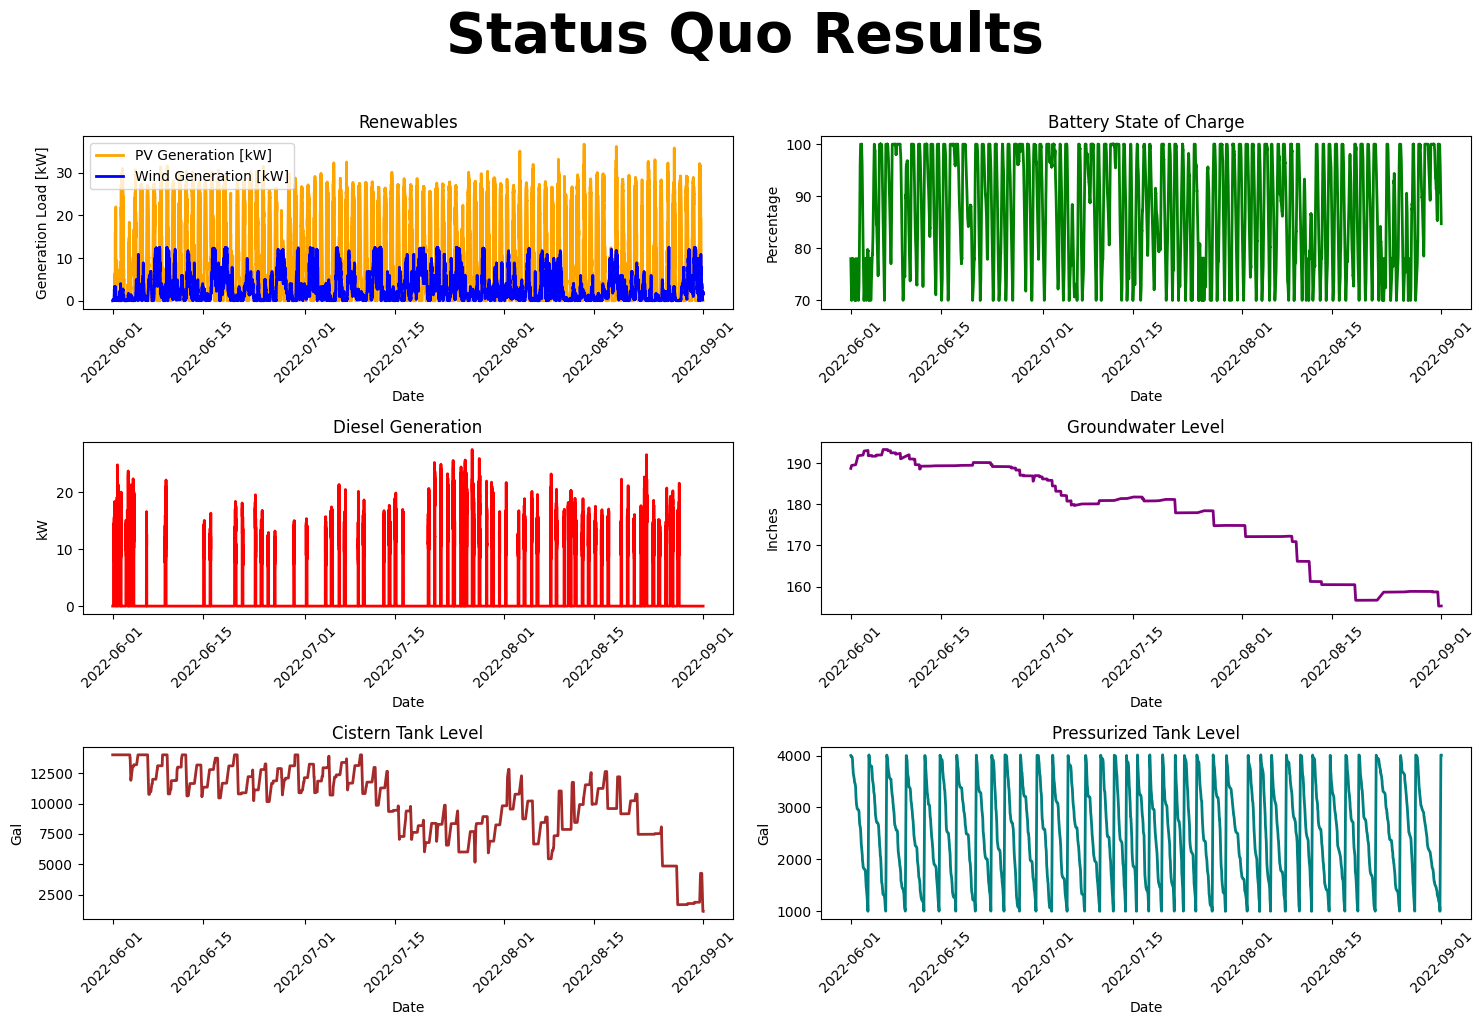

In [16]:
# Set the figure size and layout
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 columns

# Main title for the entire figure
fig.suptitle("Status Quo Results", fontsize=40, fontweight='bold', y=1.02)

# 1. Renewables generation plot
axs[0, 0].plot(Results_SQ['Date'], Results_SQ['PV_Gen_kW'], label='PV Generation [kW]', color='orange', linewidth=2)
axs[0, 0].plot(Results_SQ['Date'], Results_SQ['Wind_Gen_kW'], label='Wind Generation [kW]', color='blue', linewidth=2)
axs[0, 0].set_title('Renewables')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Generation Load [kW]')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Battery State of Charge plot
axs[0, 1].plot(Results_SQ['Date'], Results_SQ['SOC_c'], label='SOC', color='green', linewidth=2)
axs[0, 1].set_title('Battery State of Charge')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Percentage')
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Diesel generation plot
axs[1, 0].plot(Results_SQ['Date'], Results_SQ['Diesel_Gen_kW'], color='red', linewidth=2)
axs[1, 0].set_title('Diesel Generation')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('kW')
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Groundwater level plot
axs[1, 1].plot(Results_SQ['Date'], Results_SQ['Ground_Water_Depth'], color='purple', linewidth=2)
axs[1, 1].set_title('Groundwater Level')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Inches')
axs[1, 1].tick_params(axis='x', rotation=45)

# 5. Cistern Tank Level plot
axs[2, 0].plot(Results_SQ['Date'], Results_SQ['Cistern_Tank'], color='brown', linewidth=2)
axs[2, 0].set_title('Cistern Tank Level')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Gal')
axs[2, 0].tick_params(axis='x', rotation=45)

# 6. Pressurized Tank Level plot
axs[2, 1].plot(Results_SQ['Date'], Results_SQ['Pressure_Tank'], color='teal', linewidth=2)
axs[2, 1].set_title('Pressurized Tank Level')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Gal')
axs[2, 1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()